# LTFS Data Science FinHack 2

LTFS receives a lot of requests for its various finance offerings that include housing loan, two-wheeler loan, real estate financing and micro loans. The number of applications received is something that varies a lot with season. Going through these applications is a manual process and is tedious. Accurately forecasting the number of cases received can help with resource and manpower management resulting into quick response on applications and more efficient processing.

## Problem Statement
You have been appointed with the task of forecasting daily cases for next 3 months for 2 different business segments aggregated at the country level keeping in consideration the following major Indian festivals (inclusive but not exhaustive list): Diwali, Dussehra, Ganesh Chaturthi, Navratri, Holi etc. (You are free to use any publicly available open source external datasets). Some other examples could be:

Weather Macroeconomic variables Note that the external dataset must belong to a reliable source.

Data Dictionary The train data has been provided in the following way:

* For business segment 1, historical data has been made available at branch ID level For business segment 2, historical data has been made available at State level.

Train File Variable Definition application_date Date of application segment Business Segment (1/2) branch_id Anonymised id for branch at which application was received state State in which application was received (Karnataka, MP etc.) zone Zone of state in which application was received (Central, East etc.) case_count (Target) Number of cases/applications received

Test File Forecasting needs to be done at country level for the dates provided in test set for each segment.

Variable Definition id Unique id for each sample in test set application_date Date of application segment Business Segment (1/2)

### Evaluation
Evaluation Metric The evaluation metric for scoring the forecasts is **MAPE (Mean Absolute Percentage Error)* M with the formula:


Where At is the actual value and Ft is the forecast value.

The Final score is calculated using MAPE for both the segments using the formula:

**Reference taken from this github link**

https://github.com/rajat5ranjan/AV-LTFS-Data-Science-FinHack-2

In [1]:
import numpy as np
import pandas as pd
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,GroupKFold

In [2]:
train=pd.read_csv('../input/ltfs-2/train_fwYjLYX.csv')
test=pd.read_csv('../input/ltfs-2/test_1eLl9Yf.csv')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [5]:
train['application_date']=pd.to_datetime(train['application_date'])
test['application_date']=pd.to_datetime(test['application_date'])

In [6]:
import holidays
hol_list = holidays.IND(years = [2017,2018,2019])
hol_list = [date for date,name in hol_list.items()]
train['hol'] = train['application_date'].isin(hol_list) * 1
test['hol'] = test['application_date'].isin(hol_list) * 1

In [7]:
def dateFeatures(df, label=None,seg=None):
    features = ['day','week','dayofweek','month','quarter','year','dayofyear','weekofyear','is_month_start','is_month_end','is_quarter_start','is_quarter_end','is_year_start','is_year_end']
    date = df['application_date']
    for col in features:
        df[col] = getattr(date.dt,col) * 1

Based on the segment, We will split dataset into two.

In [8]:
train = train[['application_date','segment','case_count']]
train_s1=train[train['segment']==1].groupby(['application_date']).sum().reset_index().sort_values('application_date')
train_s2=train[train['segment']==2].groupby(['application_date']).sum().reset_index().sort_values('application_date')
test_s1=test[test['segment']==1][['application_date']].sort_values('application_date')
test_s2=test[test['segment']==2][['application_date']].sort_values('application_date')

In [9]:
dateFeatures(train_s1)
dateFeatures(train_s2)
dateFeatures(test_s1)
dateFeatures(test_s2)

In [10]:
test_s2.head()

,application_date,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
87,2019-07-24,24,30,2,7,3,2019,205,30,0,0,0,0,0,0
88,2019-07-25,25,30,3,7,3,2019,206,30,0,0,0,0,0,0
89,2019-07-26,26,30,4,7,3,2019,207,30,0,0,0,0,0,0
90,2019-07-27,27,30,5,7,3,2019,208,30,0,0,0,0,0,0
91,2019-07-28,28,30,6,7,3,2019,209,30,0,0,0,0,0,0


Outlier detection

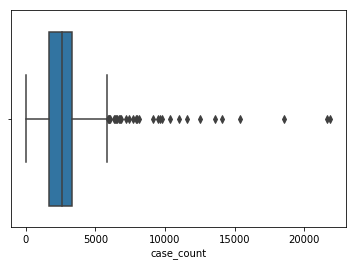

In [11]:
sns.boxplot(train_s1['case_count'])

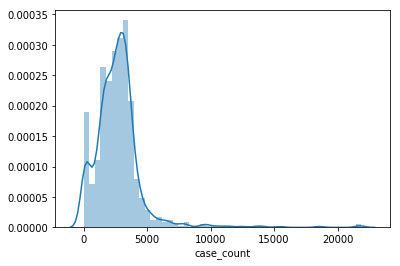

In [12]:
sns.distplot(train_s1['case_count'])

In [13]:
train_s1['case_count'].describe()

count      806.000000
mean      2714.689826
std       2042.418090
min          1.000000
25%       1633.250000
50%       2602.000000
75%       3333.000000
max      21885.000000
Name: case_count, dtype: float64

Case counts are rightly skewed let's analyse the maximum value data

In [14]:
case_max = train_s1['case_count'].max()
train_s1[train_s1['case_count']==case_max]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
344,2018-03-31,83,21885.0,31,13,5,3,1,2018,90,13,0,1,0,1,0,0


Observation : 
Maximum case count recorded date was 1 year earlier than the given data
It was a Saturday
The count was higher might be either employee has to finish their target or simulated value. So, Let's analyse the same day on previous and next year

In [15]:
train_s1[(train_s1['application_date'] >= '2017-03-01') & (train_s1['application_date'] <= '2017-03-31')]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end


In [16]:
train_s1[(train_s1['application_date'] >= '2018-03-01') & (train_s1['application_date'] <= '2018-03-31')]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
316,2018-03-01,83,88.0,1,9,3,3,1,2018,60,9,1,0,0,0,0,0
317,2018-03-03,83,58.0,3,9,5,3,1,2018,62,9,0,0,0,0,0,0
318,2018-03-05,83,3243.0,5,10,0,3,1,2018,64,10,0,0,0,0,0,0
319,2018-03-06,83,2645.0,6,10,1,3,1,2018,65,10,0,0,0,0,0,0
320,2018-03-07,83,2821.0,7,10,2,3,1,2018,66,10,0,0,0,0,0,0
321,2018-03-08,83,2794.0,8,10,3,3,1,2018,67,10,0,0,0,0,0,0
322,2018-03-09,83,2832.0,9,10,4,3,1,2018,68,10,0,0,0,0,0,0
323,2018-03-10,83,2348.0,10,10,5,3,1,2018,69,10,0,0,0,0,0,0
324,2018-03-11,83,1324.0,11,10,6,3,1,2018,70,10,0,0,0,0,0,0
325,2018-03-12,83,3468.0,12,11,0,3,1,2018,71,11,0,0,0,0,0,0


In [17]:
train_s1[(train_s1['application_date'] >= '2019-03-01') & (train_s1['application_date'] <= '2019-03-31')]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
679,2019-03-01,83,2607.0,1,9,4,3,1,2019,60,9,1,0,0,0,0,0
680,2019-03-02,83,533.0,2,9,5,3,1,2019,61,9,0,0,0,0,0,0
681,2019-03-03,83,1619.0,3,9,6,3,1,2019,62,9,0,0,0,0,0,0
682,2019-03-04,83,4596.0,4,10,0,3,1,2019,63,10,0,0,0,0,0,0
683,2019-03-05,83,2947.0,5,10,1,3,1,2019,64,10,0,0,0,0,0,0
684,2019-03-06,83,3163.0,6,10,2,3,1,2019,65,10,0,0,0,0,0,0
685,2019-03-07,83,3189.0,7,10,3,3,1,2019,66,10,0,0,0,0,0,0
686,2019-03-08,83,3488.0,8,10,4,3,1,2019,67,10,0,0,0,0,0,0
687,2019-03-09,83,2491.0,9,10,5,3,1,2019,68,10,0,0,0,0,0,0
688,2019-03-10,83,1526.0,10,10,6,3,1,2019,69,10,0,0,0,0,0,0


It seems that value was simulated one. So, lets review some of higher case count values

In [18]:
train_s1[train_s1['case_count'] > 7000]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
83,2017-06-30,83,9750.0,30,26,4,6,2,2017,181,26,0,1,0,1,0,0
110,2017-07-31,83,11594.0,31,31,0,7,3,2017,212,31,0,1,0,0,0,0
140,2017-08-31,83,13590.0,31,35,3,8,3,2017,243,35,0,1,0,0,0,0
166,2017-09-30,83,21631.0,30,39,5,9,3,2017,273,39,0,1,0,1,0,0
183,2017-10-17,83,7223.0,17,42,1,10,4,2017,290,42,0,0,0,0,0,0
197,2017-10-31,83,15429.0,31,44,1,10,4,2017,304,44,0,1,0,0,0,0
258,2017-12-31,83,14106.0,31,52,6,12,4,2017,365,52,0,1,0,1,0,1
288,2018-01-31,83,9628.0,31,5,2,1,1,2018,31,5,0,1,0,0,0,0
315,2018-02-28,83,9134.0,28,9,2,2,1,2018,59,9,0,1,0,0,0,0
344,2018-03-31,83,21885.0,31,13,5,3,1,2018,90,13,0,1,0,1,0,0


In [19]:
train_s1[train_s1['case_count']<20]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
30,2017-05-08,83,4.0,8,19,0,5,2,2017,128,19,0,0,0,0,0,0
54,2017-06-01,83,3.0,1,22,3,6,2,2017,152,22,1,0,0,0,0,0
85,2017-07-02,83,5.0,2,26,6,7,3,2017,183,26,0,0,0,0,0,0
112,2017-08-03,83,2.0,3,31,3,8,3,2017,215,31,0,0,0,0,0,0
113,2017-08-04,83,1.0,4,31,4,8,3,2017,216,31,0,0,0,0,0,0
114,2017-08-05,83,4.0,5,31,5,8,3,2017,217,31,0,0,0,0,0,0
115,2017-08-06,83,3.0,6,31,6,8,3,2017,218,31,0,0,0,0,0,0
141,2017-09-04,83,6.0,4,36,0,9,3,2017,247,36,0,0,0,0,0,0
202,2017-11-05,83,6.0,5,44,6,11,4,2017,309,44,0,0,0,0,0,0
345,2018-04-01,83,2.0,1,13,6,4,2,2018,91,13,1,0,1,0,0,0


In [20]:
train_s1 = train_s1[(train_s1['case_count'] > 20) & (train_s1['case_count'] < 7000)]

In [21]:
train_s1 = train_s1[train_s1['case_count']<=10000]
train_s1=train_s1.reset_index().drop('index',axis=1)

Outlier detection

In [22]:
train_s2.describe()

,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
count,844.0,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.00000,844.00000
mean,32.0,15077.098341,15.613744,25.812796,3.000000,6.374408,2.468009,2017.915877,178.204976,25.812796,0.033175,0.031991,0.011848,0.010664,0.00237,0.00237
std,0.0,10188.900682,8.766381,14.165285,2.004148,3.255744,1.054919,0.749082,99.537337,14.165285,0.179200,0.176079,0.108267,0.102773,0.04865,0.04865
min,32.0,206.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,32.0,5946.000000,8.000000,15.000000,1.000000,4.000000,2.000000,2017.000000,101.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,32.0,12679.000000,16.000000,25.000000,3.000000,6.000000,2.000000,2018.000000,171.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
75%,32.0,24217.250000,23.000000,37.000000,5.000000,9.000000,3.000000,2018.000000,260.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
max,32.0,43340.000000,31.000000,52.000000,6.000000,12.000000,4.000000,2019.000000,365.000000,52.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


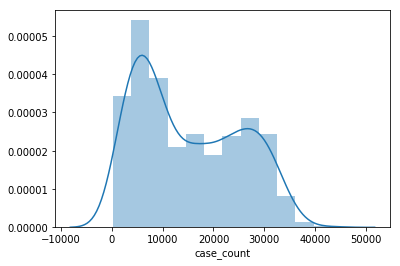

In [23]:
sns.distplot(train_s2['case_count'])

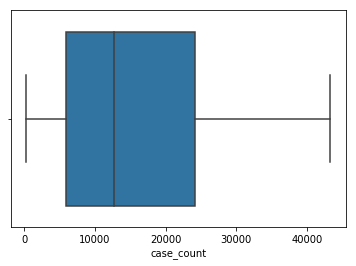

In [24]:
sns.boxplot(train_s2['case_count'])

In [25]:
train_s2[train_s2['case_count']>35000]

,application_date,segment,case_count,day,week,dayofweek,month,quarter,year,dayofyear,weekofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
446,2018-06-21,32,35131.0,21,25,3,6,2,2018,172,25,0,0,0,0,0,0
471,2018-07-16,32,37253.0,16,29,0,7,3,2018,197,29,0,0,0,0,0,0
474,2018-07-19,32,43340.0,19,29,3,7,3,2018,200,29,0,0,0,0,0,0
476,2018-07-21,32,35356.0,21,29,5,7,3,2018,202,29,0,0,0,0,0,0
499,2018-08-13,32,36414.0,13,33,0,8,3,2018,225,33,0,0,0,0,0,0
500,2018-08-14,32,35203.0,14,33,1,8,3,2018,226,33,0,0,0,0,0,0
503,2018-08-17,32,35614.0,17,33,4,8,3,2018,229,33,0,0,0,0,0,0
712,2019-03-14,32,38345.0,14,11,3,3,1,2019,73,11,0,0,0,0,0,0
713,2019-03-15,32,36212.0,15,11,4,3,1,2019,74,11,0,0,0,0,0,0


In [26]:
train_s2 = train_s2[train_s2['case_count']<36000]
train_s2=train_s2.reset_index().drop('index',axis=1)

In [27]:
y1 = train_s1['case_count']
y2 = train_s2['case_count']
train_s1.drop(['case_count','segment','application_date'],axis=1,inplace=True)
train_s2.drop(['case_count','segment','application_date'],axis=1,inplace=True)

In [28]:
test_s1.drop(['application_date'],axis=1,inplace=True)
test_s2.drop(['application_date'],axis=1,inplace=True)

In [29]:
kf=GroupKFold(n_splits=20)
s1models = []
s2models = []

X = train_s1
y = y1
loss = []

print("loss:")
grp = train_s1['day'].values
for train_index, test_index in kf.split(X,y,grp):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model=RandomForestRegressor(n_estimators = 150 ,random_state=42,max_features =8)
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    print(mean_absolute_percentage_error(y_test,preds))
    loss.append(mean_absolute_percentage_error(y_test,preds))
    s1models.append(model.predict(test_s1))

loss:
360.82669864666093
100.71517312463037
86.15114563185561
17.230207343866923
13.38535741176118
145.95642094659115
18.539629825361047
15.29164231515128
9.823251121835535
10.162489987362866
10.778691171466598
19.04620199220622
9.221802653619342
104.82802697450086
102.46288920037144
35.407361791336854
190.62011713532772
17.184818423183824
80.80770871379903
214.15478225689978


In [30]:
s1models = s1models[1:19]

In [31]:
X = train_s2
y = y2
loss = []
print("loss : ")
grp = train_s2['dayofyear'].values
for train_index, test_index in kf.split(X,y,grp):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model=RandomForestRegressor(n_estimators=150,random_state=42,max_features=8)
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    print(mean_absolute_percentage_error(y_test,preds))
    loss.append(mean_absolute_percentage_error(y_test,preds))
    s2models.append(model.predict(test_s2))

loss : 
33.213912407038606
29.34161315960661
127.63935733807321
27.54398723083676
34.880241661375436
22.787144799995623
16.599678634645517
19.26766436810047
13.408251805995139
10.458011025586023
10.426391018122397
22.701862092768785
19.843668077814083
26.303543404252583
11.4259274842432
22.443549715125112
13.40178643867373
19.872448976404907
19.59186642326222
23.85713254542356


In [32]:
del s2models[2]

In [33]:
test.loc[test.segment==1, 'case_count']=np.mean(s1models,0)
test.loc[test.segment==2, 'case_count']=np.mean(s2models,0)

In [34]:
test.to_csv('submission.csv',index=False) 